In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
omegas_df = pd.read_csv('omegas-seed01.csv', index_col=0)
traces_df = pd.read_csv('traces-seed01.csv', index_col=0)
deltas_df = pd.read_csv('deltas-seed01.csv', index_col=0)
mus_df = pd.read_csv('mus-seed01.csv', index_col=0)
pis_df = pd.read_csv('pis-seed01.csv', index_col=0)

FIG_SIZE_LARGE = (12.0, 5.0)
FIG_SIZE_SMALL = (6.0, 4.0)


# Overflow 


This notebook is an attempt to diagnose the causes that lead to a parametric overflow during learning that effectivelly prevents the agent to learn an usefull policy. 

**Proposal** The issue is caused by a lack of exploration and may be circunvented by using parameter clipping techiniques. 

```
    delta = np.clip(delta, -1, 1)
    omega = np.clip(omega, -0.5, 0.5)

```

To reproduce set the configuration in the file `config.py` to:

```
    ALPHA = 0.5  # ALPHA: critic learning rate
    BETA = 0.3  # BETA: actor learning rate
    TAU = 1.0   # FINAL TEMPERATURE PARAMETER. Goes from 100 to TAU
    EXPLORE_EPISODES = 450  # Number of episodes 
    EXPLORE = True  # WHETER OR NOT WE USE EXPLORATION
    RESTART = False  # Restart agents' position.

    SEED = 1
    BASE_PATH = 'data/06_no_clip/00_tau01'
```
Where `tau` is a temperature parameter associated with exploratory behaviour. The larger it is the more indiferent the agent will be towards selecting the greedy action. It appears dividing the score, approximate Q-value of a boltzman policy.

And run `python central.py`


In [3]:
# States before update
x0df = omegas_df[['x_a', 'y_a', 'v_x', 'v_y', 'x_r', 'y_r']]

# Deltas
ddf = omegas_df[['deltas']]

# Critic parameters before update
w0df  = omegas_df[['w0_%s' % str(i)  for i in range(1, 7)]]

# Critic parameters after update
w1df  = omegas_df[['w1_%s' % str(i)  for i in range(1, 7)]]

## 1. X(st)

In [4]:
x0df.describe()

,x_a,y_a,v_x,v_y,x_r,y_r
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,-0.782689,-0.058117,-0.143321,-0.081240,-0.217083,-0.337218
std,0.699277,1.330027,0.483693,0.503276,0.699277,1.330027
min,-8.966004,-15.559351,-1.999841,-2.000000,-2.417481,-1.635937
25%,-1.219361,-0.134674,-0.499009,-0.409442,-0.772471,-0.835984
50%,-0.574499,0.187913,0.000000,0.000000,-0.425272,-0.583248
75%,-0.227300,0.440649,0.133632,0.278661,0.219590,-0.260661
max,1.417710,1.240602,1.387780,1.766909,7.966233,15.164016


Where:
- `x_a` x coordinates of the agent's position (columns or rows?).
- `y_a` y coordinates of the agent's position (columns or rows?).
- `v_x` x coordinates of the agent's velocity.
- `v_y` y coordinates of the agent's velocity.
- `x_r` x coordinates of the relative position landmark to agent.
- `y_r` y coordinates of the relative position landmark to agent.

### Notes 

- There is a total of `45000` steps `450` episodes or `100` timesteps each before reset.
- The board goes from -1 to +1 on both axis. Whereas the max coordinates `x_a=1.417710`and `y_a=1.240602` remain reasonably confined within bounds the min. coordinates `x_a=-8.966004`and `y_a=-15.559351` do not.
- Conversely the min. coordinates `x_r=-2.417481`and `y_r=-0.337218` remain reasonably confined within bounds the max. coordinates `x_r=7.966233`and `y_r=15.164016` do not.
- The coordinates for the velocities remain bounded to the interval `[-2, 2]`




## 2. Wt

In [14]:
## 2. Wt The critic parameters during learning.
w0df.describe()

,w0_1,w0_2,w0_3,w0_4,w0_5,w0_6
count,4.385700e+04,4.385700e+04,4.385700e+04,4.385700e+04,4.385700e+04,4.385700e+04
mean,inf,inf,inf,inf,-inf,-inf
std,NaN,NaN,NaN,NaN,NaN,NaN
min,-3.252474e+11,-8.078905e+00,-3.020797e+11,-2.190414e+10,-inf,-inf
25%,-1.304264e-01,3.363151e-01,-7.827989e-01,-5.156392e-01,1.271558e+00,4.007845e-01
50%,4.053284e-01,7.408172e-01,-4.844164e-01,-3.471481e-01,3.538021e+00,9.775570e-01
75%,2.428899e+00,1.160186e+00,8.569177e-02,2.612595e-02,4.502653e+00,1.396351e+00
max,inf,inf,inf,inf,1.307780e+11,6.539835e+00


### Notes

- The parameters are reported before the update on a given timestep.
- The update stops on timestep `43570` before reaching `inf` and `-inf`.
- At least 50% of the samples remain at reasonable bound, e.g, the 25% quantile of `w0_1=-0.13` and the 75% quantile of `w0_1=2.42`. 

Conclusion we should observe what happens by timestep `42000` onwards. We now perform breakdowns from the first part of "normal" training and the second part of "problematic" training.

### 2.1 Wt Regular  (0-42000)

The first part of "normal" training consists of the first `42000` observations.

In [5]:
w0df.loc[:41999].describe()

,w0_1,w0_2,w0_3,w0_4,w0_5,w0_6
count,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000
mean,1.148523,0.685642,-0.386678,-0.283374,3.052991,0.975743
std,2.001334,0.698387,0.613342,0.383395,2.020132,0.767159
min,-4.130505,-2.611567,-3.315544,-5.306443,-9.644430,-4.059063
25%,-0.131302,0.328835,-0.785497,-0.515639,1.357681,0.468265
50%,0.331511,0.735410,-0.492800,-0.363211,3.630746,1.005625
75%,2.149774,1.094920,0.036060,-0.029787,4.513379,1.413482
max,15.379022,6.688374,4.123223,2.163366,7.478788,5.703751


<AxesSubplot:>

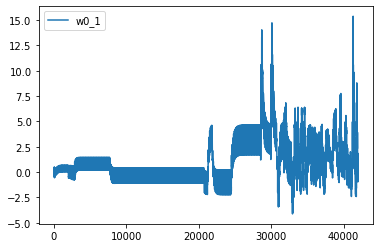

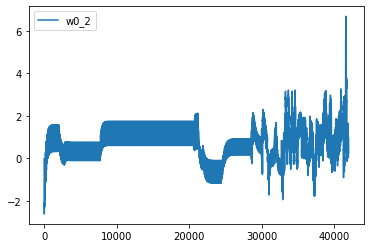

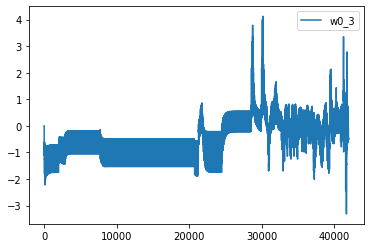

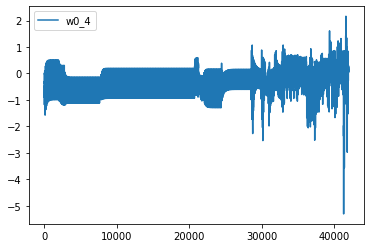

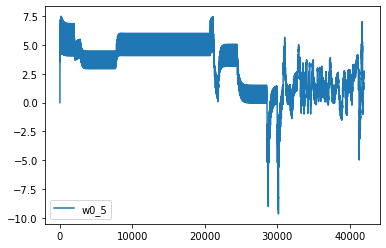

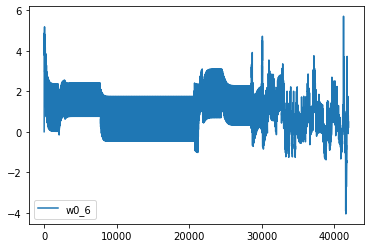

In [6]:
w0df.loc[:41999, ['w0_1']].plot(figsize=FIG_SIZE_SMALL)
w0df.loc[:41999, ['w0_2']].plot(figsize=FIG_SIZE_SMALL)
w0df.loc[:41999, ['w0_3']].plot(figsize=FIG_SIZE_SMALL)
w0df.loc[:41999, ['w0_4']].plot(figsize=FIG_SIZE_SMALL)
w0df.loc[:41999, ['w0_5']].plot(figsize=FIG_SIZE_SMALL)
w0df.loc[:41999, ['w0_6']].plot(figsize=FIG_SIZE_SMALL)

We can note that the as the temperature parameter falls to one (linearly) the behavior of the parameter becomes more volatile. I would expect the opposite to happen, more variation with a higher temperature parameter `tau`.

<AxesSubplot:title={'center':'Temperature parameter'}, xlabel='episode'>

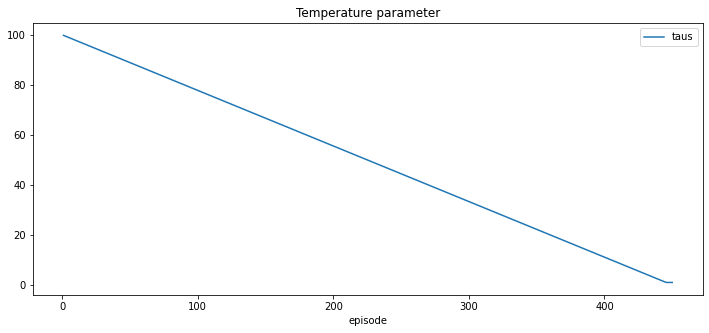

In [70]:
taudf = pis_df['taus'].to_frame()
taudf['episode'] = (taudf.index.values// 100) + 1  

taupt = taudf.pivot_table(index='episode', aggfunc=np.mean)
taupt.plot(figsize=FIG_SIZE_LARGE, c='C0', title='Temperature parameter')

### 2.2 Wt Problem starts (42000-43000)

In [7]:
w0df.loc[42000:43000, :].describe()    # 1000 timesteps

,w0_1,w0_2,w0_3,w0_4,w0_5,w0_6
count,1.001000e+03,1.001000e+03,1.001000e+03,1.001000e+03,1.001000e+03,1.001000e+03
mean,5.450093e+87,2.464227e+88,1.756149e+77,3.238363e+87,-3.831282e+87,-2.400215e+88
std,1.322400e+89,6.001302e+89,3.866818e+78,7.857499e+88,9.296147e+88,5.845986e+89
min,-3.252474e+11,-8.078905e+00,-3.020797e+11,-2.190414e+10,-2.842552e+90,-1.789272e+91
25%,-1.161086e-01,2.821005e-01,-5.689479e-01,-2.390135e-01,-2.784324e+14,-6.959486e+14
50%,2.040021e+00,1.111916e+00,-7.024398e-02,2.797456e-01,1.530173e+00,1.491167e-01
75%,4.199280e+14,7.518995e+14,5.178042e+00,2.830603e+14,2.479342e+00,8.538783e-01
max,4.043600e+90,1.836764e+91,1.148922e+80,2.402646e+90,1.307780e+11,6.539835e+00


On the next 1000 timesteps the critic parameters run off bounds. We can compare the first 42000 timesteps and the 600 timesteps from 42000 to 42600:

### 2.3 Wt Breakdown  (42000-42670)

In [66]:
print(w0df.loc[:41999].describe()) # 0-42000 timesteps
w0df.loc[42000:42670].describe()  # 42000-42600 timesteps

               w0_1          w0_2          w0_3          w0_4          w0_5  \
count  42000.000000  42000.000000  42000.000000  42000.000000  42000.000000   
mean       1.148523      0.685642     -0.386678     -0.283374      3.052991   
std        2.001334      0.698387      0.613342      0.383395      2.020132   
min       -4.130505     -2.611567     -3.315544     -5.306443     -9.644430   
25%       -0.131302      0.328835     -0.785497     -0.515639      1.357681   
50%        0.331511      0.735410     -0.492800     -0.363211      3.630746   
75%        2.149774      1.094920      0.036060     -0.029787      4.513379   
max       15.379022      6.688374      4.123223      2.163366      7.478788   

               w0_6  
count  42000.000000  
mean       0.975743  
std        0.767159  
min       -4.059063  
25%        0.468265  
50%        1.005625  
75%        1.413482  
max        5.703751  


,w0_1,w0_2,w0_3,w0_4,w0_5,w0_6
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,0.630734,2.420706,-1.516087,0.513109,2.225047,-1.291458
std,13.981451,7.081346,6.808331,3.962537,8.907675,7.897244
min,-181.368125,-8.078905,-84.663822,-5.539018,-11.205405,-80.160491
25%,-0.397057,0.005162,-0.571517,-0.404253,1.155499,0.147292
50%,0.600743,0.521515,-0.334038,-0.000843,1.755153,0.610853
75%,2.834941,1.122448,0.112423,0.318954,2.539387,1.033179
max,20.772017,53.014683,5.178042,47.850142,112.718477,6.539835


<AxesSubplot:>

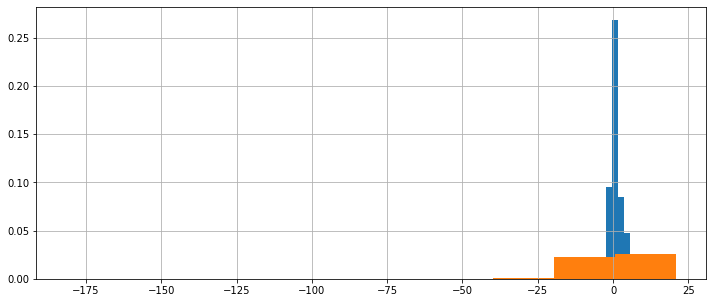

In [68]:
w0df.loc[:41999, 'w0_1'].hist(density=True, color='C0', label='regular', figsize=FIG_SIZE_LARGE)
w0df.loc[42000:42670, 'w0_1'].hist(density=True, color='C1', label='issue', figsize=FIG_SIZE_LARGE)

### Notes

- The tables and histograms above should convice that the data generating process is not the same.
- Furthermore, at latter parts of the training $\tau \approx 1.0$ should select actions in proporsion to their probabilities in a stochastic policy. It would be expected that the parameter should be more stable whereas the opposite is happening. The mean is different and there is also more standard deviation on the estimates.

There is a chicken and egg going on. Because, $\omega_t$ explodes it should lead $\delta_t$ should also oscilate erratically, which taints gradient computation for the actor.

## 3. Delta 

Debugging numerical optimizaition problems can be dauting as initially small differences can grow over time and the parameters depend on lagged versions of other parameters. The $\delta_t$ actually communicates the evaluation from the critic to the gradient $\nabla_{\Theta_t}\log\pi(s_t, a_t; \Theta_t)$.

In [26]:
deltas_df.head()

,deltas,rewards,mus,dx_a,dy_a,dv_x,dv_y,dx_r,dy_r,w0_1,w0_2,w0_3,w0_4,w0_5,w0_6
0,-1.180727,-1.180727,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,-1.118193,-1.216552,-0.118073,0.050000,0.0,0.500000,0.0,-0.050000,0.0,0.097974,-0.260143,0.000000,0.0,0.492254,0.493534
2,-1.042958,-1.244062,-0.229892,0.037500,0.0,-0.125000,0.0,-0.037500,0.0,0.190760,-0.506508,0.000000,0.0,0.958437,0.960930
3,-0.939253,-1.265032,-0.334188,0.028125,0.0,-0.093750,0.0,-0.028125,0.0,0.251228,-0.736298,-0.260740,0.0,1.419329,1.396878
4,-0.855099,-1.280939,-0.428113,0.021094,0.0,-0.070312,0.0,-0.021094,0.0,0.288073,-0.943238,-0.436849,0.0,1.852002,1.789478


<br><br>
We now move to plot TD-error (for linear function value approximation): $\delta_t = (r_{t+1} - \mu_t) + \Delta x_t \times \omega_t$ 
<br><br>
Where: $\Delta x_t = x_{t+1} - x_t$. 
<br><br>
We can break the TD-erro into two components a difference in instaneous rewards and of expectations:
<br><br>
$\delta_t = \Delta r_t + \Delta v_t$. 

/home/gsavarela/.local/share/.pyenv/versions/3.9.6/envs/t39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:xlabel='episodes'>

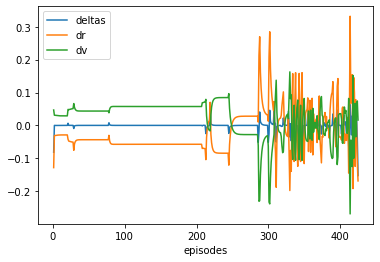

In [75]:
# dr = r_{t+1} - mu_t
drdf = (deltas_df['rewards'] - deltas_df['mus']).to_frame().rename(columns={0: 'dr'})

# dv = v(s_{t+1}, w) - v(s_t, w)
dX = deltas_df[['dx_a', 'dy_a', 'dv_x', 'dv_y', 'dx_r', 'dy_r']].values
W0 = deltas_df[['w0_1', 'w0_2', 'w0_3', 'w0_4', 'w0_5', 'w0_6']].values

dvdf = pd.DataFrame(data=np.sum(dX * W0, axis=1), columns=['dv'])

dataframes = [deltas_df['deltas'].to_frame(), drdf, dvdf]
tddf = pd.concat(dataframes, axis=1)
tddf['episodes'] = (tddf.index.values // 100) + 1
tdpt = tddf.pivot_table(index='episodes', aggfunc=np.mean)
tdpt.loc[:425].plot()

<AxesSubplot:xlabel='episodes'>

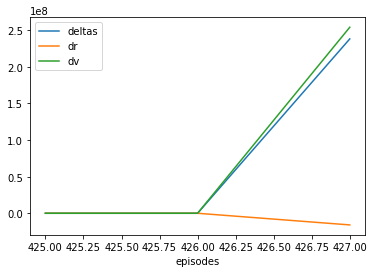

In [72]:
pttd.loc[425:427].plot()


<AxesSubplot:title={'center':'Exploding Deltas'}, xlabel='timestep'>

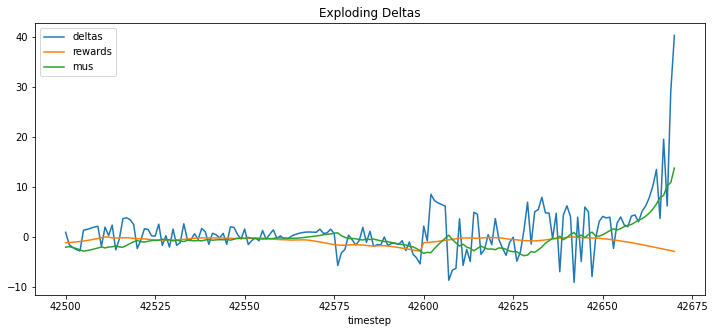

In [80]:
deltas_df.loc[42500:42670, ['deltas', 'rewards', 'mus']].plot(
    figsize=FIG_SIZE_LARGE,
    title='Exploding Deltas',
    xlabel='timestep'
)

### Notes:

- We can now better pinpoint time step `42670-42675` is when things start come apart. 
- By construction if the agent hovers around the landmark than $x_{t+1} = x_t$ and $r_{t+1} = 0$ and $\delta_t = -\mu_t$ where $\mu_t < 0$. The agent should learn the control to hover over the goal.
- Up until timestep `42600` the process was reasonably well behaved and $\Delta v_t$ bounded.
- After `42600`. What we see in the picture above is that $\Delta v_t$ starts growing fast.

- Extreme $\omega_t$, lead to extreme $\Delta v_t$. What can we say about the states and actions by the timestep `42600`.

## 4. X(s_t) Revisited:

Our goal now is to determine if there is an extrapolation error -- or because the evaluations of the policy are fluctuating wildly the agent is now visiting other states.

In [83]:
print(x0df.loc[:42599].describe()) # 0-42000 timesteps
x0df.loc[42600:42670].describe()  # 42000-42600 timesteps

                x_a           y_a           v_x           v_y           x_r  \
count  42600.000000  42600.000000  42600.000000  42600.000000  42600.000000   
mean      -0.732622      0.089394     -0.140409     -0.043282     -0.267149   
std        0.571713      0.437211      0.481239      0.434327      0.571713   
min       -2.965873     -1.695861     -1.644043     -1.579452     -2.417481   
25%       -1.196023     -0.126448     -0.504291     -0.358331     -0.747807   
50%       -0.572820      0.183982      0.000000      0.000000     -0.426951   
75%       -0.251964      0.440649      0.163396      0.289348      0.196252   
max        1.417710      0.730675      1.387780      1.766909      1.966102   

                y_r  
count  42600.000000  
mean      -0.484729  
std        0.437211  
min       -1.126010  
25%       -0.835984  
50%       -0.579316  
75%       -0.268887  
max        1.300526  


,x_a,y_a,v_x,v_y,x_r,y_r
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,-1.264518,-0.173524,-0.450804,0.084803,0.264746,-0.221811
std,0.716198,0.605442,0.627136,0.659193,0.716198,0.605442
min,-3.366666,-1.210513,-1.737379,-1.206306,-0.833815,-1.438084
25%,-1.353557,-0.587067,-0.915933,-0.451477,-0.098447,-0.696274
50%,-1.040667,-0.204394,-0.417628,0.178245,0.040896,-0.190941
75%,-0.901324,0.300939,0.099110,0.614806,0.353785,0.191732
max,-0.165956,1.042750,0.743833,1.142335,2.366894,0.815178


<AxesSubplot:xlabel='x_a', ylabel='y_a'>

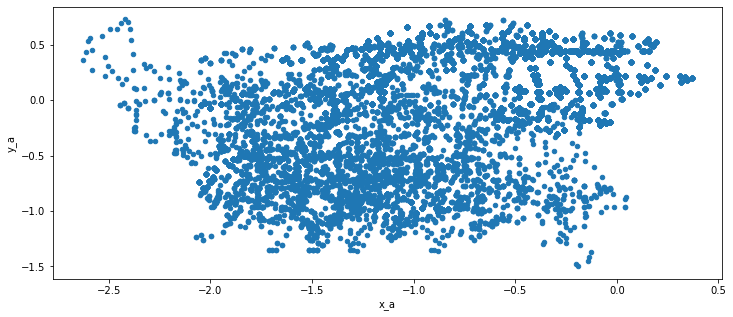

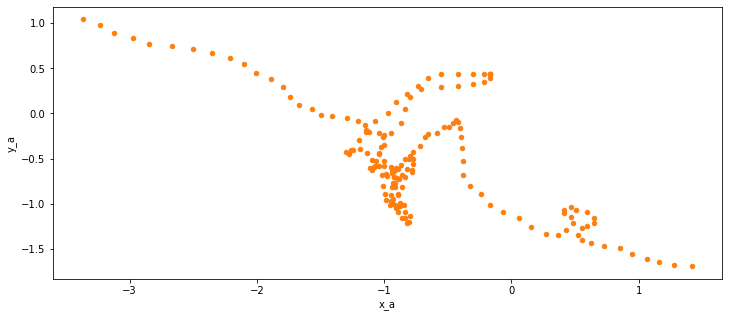

In [13]:
x0df.loc[:42149, ['x_a', 'y_a']].plot.scatter(0, 1, c='C0', figsize=FIG_SIZE_LARGE) # 0-42000 timesteps
x0df.loc[42500:42670, ['x_a', 'y_a']].plot.scatter(0, 1, c='C1', figsize=FIG_SIZE_LARGE)  # 42000-42600 timesteps

### Notes:

Looking at the scatter plots above we can see that there are accually new states being visited `x_a` orange goes -3.0. If new states are indeed being visited than the actor must be choosing the actions differently. Perhaps it's an extrapolation issue with function approximation. 

## 5. Actions analysis.

In [84]:
traces_df.head()

,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,actions,x1_1,x1_2,x1_3,x1_4,x1_5,x1_6,v(x)
0,-0.165956,0.440649,0.00000,0.0,-0.833815,-0.835984,NONE,-0.165956,0.440649,0.000000,0.0,-0.833815,-0.835984,0.000000
1,-0.165956,0.440649,0.00000,0.0,-0.833815,-0.835984,RIGHT,-0.115956,0.440649,0.500000,0.0,-0.883815,-0.835984,-0.953927
2,-0.115956,0.440649,0.50000,0.0,-0.883815,-0.835984,NONE,-0.078456,0.440649,0.375000,0.0,-0.921315,-0.835984,-1.895716
3,-0.078456,0.440649,0.37500,0.0,-0.921315,-0.835984,NONE,-0.050331,0.440649,0.281250,0.0,-0.949440,-0.835984,-2.917353
4,-0.050331,0.440649,0.28125,0.0,-0.949440,-0.835984,NONE,-0.029237,0.440649,0.210938,0.0,-0.970534,-0.835984,-3.807340


Where
- `x0_j j=1..6` is the set of features representing the states before the action.
- `actions` is the action taken at the timestep.
- `x1_j j=1..6` is the set of features representing the states after the action.
- `v(x)` is the value of the state.
- `NONE, RIGHT, LEFT, UP, DOWN` columns represent the stochastic policy's distribution before the update the sum of those five columns always sum to 1.

In the first part of the training what is the resulting action on the vertical and horizontal axis? Does it change from on the second part?

### Notes:

How to compute the empirical distribution of actions per episode?

1. Add an episode column.
2. Group by episode and consolidate by length. 
3. Transpose to have episode on columns and actions on rows.
4. Plot a graph with 5 categories.
5. See if as training progresses the agent will select obsessive behaviors.

## 5.1 Actions per episode

In [87]:
# 1. add an episode column
adf = traces_df['actions'].to_frame()
adf['episode'] = (adf.index.values // 100) + 1  

# 2. Group by episode and consolidate by length.
def fn(x): return len(x) / 100
apt = adf.pivot_table(index='episode', columns='actions', aggfunc=fn)


### 5.1.1 Actions from Episode 0-420

<AxesSubplot:xlabel='episode'>

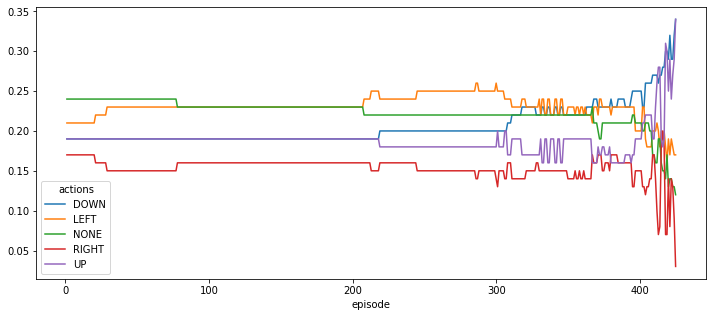

In [88]:
apt.loc[:425].plot(figsize=FIG_SIZE_LARGE)

### 5.1.2 Actions from Episode 420-450

<AxesSubplot:xlabel='episode'>

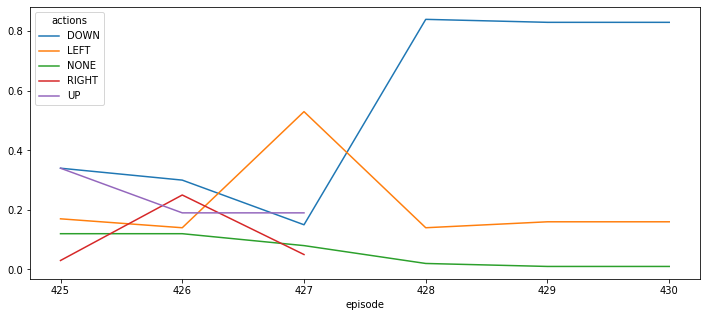

In [92]:
apt.loc[425:430].plot(figsize=FIG_SIZE_LARGE)

In [93]:
for orient in ('RIGHT', 'LEFT', 'UP', 'DOWN'):
    minobs = apt.index[np.isnan(apt[orient].values)].min()
    print(f'{orient}\t {minobs}')


RIGHT	 428
LEFT	 440
UP	 428
DOWN	 440


We can see that the actions stop being computed at the timesteps `RIGHT=427`, `LEFT=439`, `UP=427` and `DOWN=439`.

### 451.3 Actions from Episode 270-370

<AxesSubplot:xlabel='episode'>

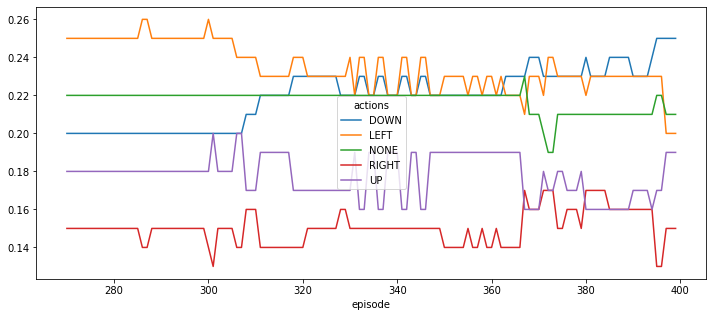

In [91]:
apt.loc[270:399].plot(figsize=FIG_SIZE_LARGE)

### Notes:

- On the figure we have moved to third quarter of the training where $\tau$ is somewhat high promoting some indifference w.r.t the action being selected. 
- The uniform distribution assign `20%` probability for the each action. But as a result of the training the `DOWN` and `LEFT` actions are above average. That is desirable because the landmark never moves and is at the third quadrant. Hence, the agent should move on the south-west direction.
- The `NONE` direction is neutral, but has the important role of regulading a move. There is a velocity dumping effect where the agent moves at the same direction prescribed by the velocity, but with less magnitude. It remains being selected `22%` of the time, or about average.
- The `UP` and `RIGHT` direction should be use to reverse the agent's movement. And hence they are less frequently choosen by the actor `18%` and `15%`.

*ALL SEEMS PLAUSIBLE*



<AxesSubplot:xlabel='episode'>

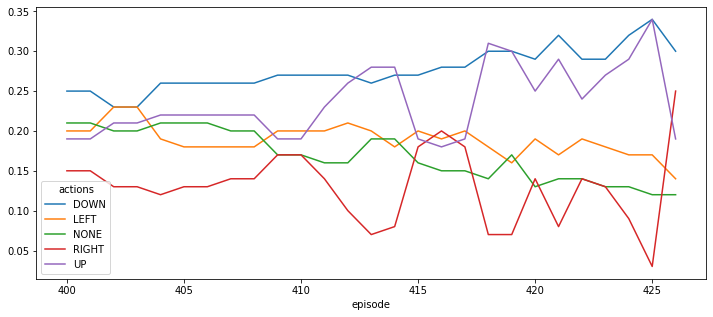

In [45]:
apt.loc[400:426].plot(figsize=FIG_SIZE_LARGE)

In [46]:
print('Frequency of action selections at episode 426')
apt.loc[426]

Frequency of action selections at episode 426


actions
DOWN     0.30
LEFT     0.14
NONE     0.12
RIGHT    0.25
UP       0.19
Name: 426, dtype: float64

### Notes:

- On the figure above we have moved to the third quarter of the training and the agent and there are two opposite behaviours.
- On the x-axis, the probability of the agents selecting the actions `RIGHT` and `LEFT` begin to fall together. They go from about `17%` and `22%` at `episode=370` to `8%` and `17%` at `episode=420`.
- The proporsion of times that `NONE` is selected also diminished, going from `22%` at `episode=370` to `14%` at `episode=420`. 
- Conversely all excess probability mass goes to actions `UP` and `DOWN`. At `episode=370`they're and respectively. At `episode=420` they go to `29%` and `32%` respectively.


### Metaphor:

For the first part of the trip, with high $\tau$ the control strategy switches from a confortable road trip with high average velocity and smooth acceleration and deaceleration, when changing directions are needed. For the second part, with low $\tau$, resambles a urban bus ride, where the objective is to cover the distance between two successive bus stops as fast as possible, having high acceleration and deacceleratio to obey a schedule. 

### Timeline.

1. Poor exploration makes the agent visit the 3rd quadrant region very frequently.
2. As $\tau$ approaches 1 agents act on a less noisy distribution and makes more extreme moves.
3. Because it makes more extreme moves it visits new states outside the range of previous' states.
4. Because it uses value function approximation it must extrapolate leading to higher TD-error ($\delta_t$).
5. Higher deltas to higher magnitude adjustments, making the agent over-compensate.
6. The agent flips actions going to the `RIGHT` instead of going to the `LEFT`.
7. The TD-error grows to be big and positive. This is important because a positive error reinforces the actions positivelly or to execute this action more frequently.
8. Because TD-error grows and the $\Delta\omega_t$ is adjusted in proporsion to $\delta_t$ $\omega_t$ eventually explodes.
9. Because $\omega_t$ grows $\Delta v(s_t, \omega_t)$ also explodes leading to $\delta_t$.
10. Because $\delta_t$ explodes $\omega_t$ and $\Theta_t$ also explode. 


### Causes:

The primary cause is the interaction of the **problems' specification** and the **reinforcement learning method**.

**reinforcement learning**

- Linear function approximation.
- Gradient methods.

**problem specification**

- Seed makes landmark and the agent at opposite extremes, resulting in having a large distance to cover, that may result in high velocities that contribute to large oscilations in speed.
 
- The random action might not be that bad. (SEE REWARDS AT BEGINING OF THE TRAINING AND THE END).

- The level curves where the gradient is updated might be very irregular, where orbits that have a large amplitude or and low frequency can lead the agent to approach the target faster but makes it hard for the agent to break. Converselly curves that initially promote a small amplitute or high frequency, making the agent oscilate before reaching the goal might be better suited for this task.

- Finally, as a result of function approximation and exploration, there is the problem of extrapolation. As new states are being visited on the latter part of the training.

**fixes**

- clipping, giving less credibility to large oscilations.
- random restarts, removing bias of generated values.
 
